<a href="https://colab.research.google.com/github/chaitubhure/Options-Writing-Predictions/blob/master/Copy_of_DebuggedStockPrediction_with_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stock Prediction model with Tensorflow 2.0! 

We're going to predict prices of General Electric's stock using a Transformer neural network

**IMPORT DATA FROM DRIVE**

In [0]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://drive.google.com/drive/u/5/folders/1GwvIddbMYiKksnXwecbq8-YPPLIDBEJl"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

if __name__ == "__main__":
    file_id = 'TAKE ID FROM SHAREABLE LINK'
    destination = 'F.csv'
    download_file_from_google_drive(file_id, destination)

## Step 1 - Import data

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [0]:
!pwd

/content


In [0]:
# Upload file without google drive

df = pd.read_csv('F.csv',delimiter=',',usecols=['Date','Open','High','Low','Close', 'Volume'])

In [0]:
# I got it from https://finance.yahoo.com/quote/GE/history?p=GE&.tsrc=fin-srch

df = pd.read_csv('drive/My Drive/BigData/F.csv',delimiter=',',usecols=['Date','Open','High','Low','Close', 'Volume'])


In [0]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()

,Date,Open,High,Low,Close,Volume
0,1972-06-01,2.149165,2.173495,2.149165,2.153220,1089200
1,1972-06-02,2.153220,2.173495,2.141055,2.149165,1173500
2,1972-06-05,2.149165,2.169440,2.141055,2.149165,5208100
3,1972-06-06,2.149165,2.157275,2.116725,2.124835,1421400
4,1972-06-07,2.124835,2.137000,2.112669,2.112669,671800


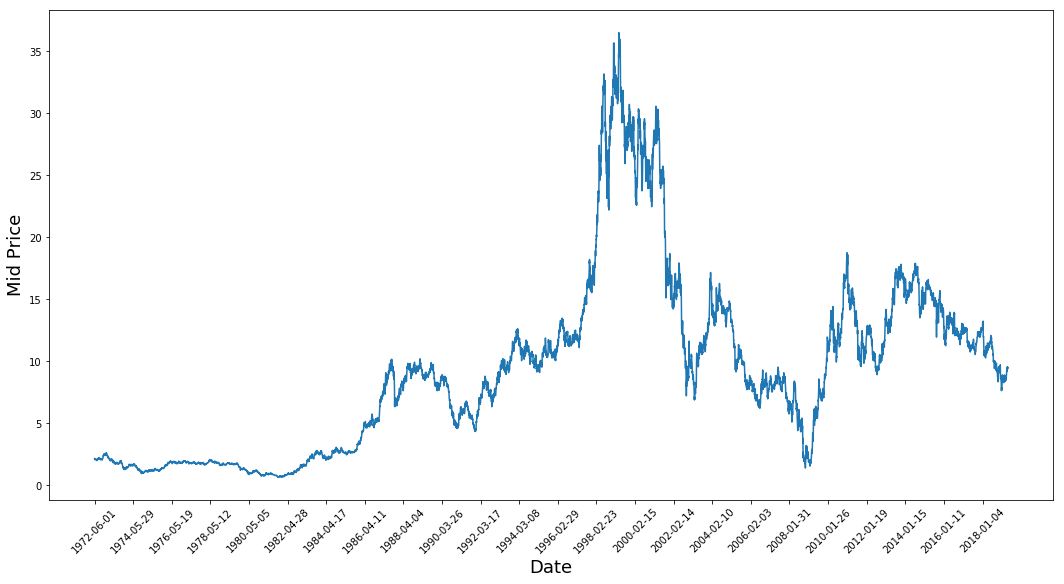

In [0]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

## Step 2 - Data preprocessing 

In [0]:
df['mid'] = (df['Low']+df['High'])/2.0

In [0]:
SEQ_LEN = 60  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "mid"

In [0]:
def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0

In [0]:
df['future'] = df[RATIO_TO_PREDICT].shift(-FUTURE_PERIOD_PREDICT)

In [0]:
df['target'] = list(map(classify, df[RATIO_TO_PREDICT], df['future']))

In [0]:
df.head()

,Date,Open,High,Low,Close,Volume,mid,future,target
0,1972-06-01,2.149165,2.173495,2.149165,2.153220,1089200,2.161330,2.157275,0
1,1972-06-02,2.153220,2.173495,2.141055,2.149165,1173500,2.157275,2.155247,0
2,1972-06-05,2.149165,2.169440,2.141055,2.149165,5208100,2.155247,2.137000,0
3,1972-06-06,2.149165,2.157275,2.116725,2.124835,1421400,2.137000,2.124834,0
4,1972-06-07,2.124835,2.137000,2.112669,2.112669,671800,2.124834,2.112669,0


In [0]:
df.tail()

,Date,Open,High,Low,Close,Volume,mid,future,target
11822,2019-04-17,9.40,9.58,9.39,9.50,30688300,9.485,9.550,1
11823,2019-04-18,9.52,9.62,9.48,9.55,29843000,9.550,9.520,0
11824,2019-04-22,9.58,9.58,9.46,9.50,38718500,9.520,9.405,0
11825,2019-04-23,9.36,9.51,9.30,9.50,39493700,9.405,9.505,1
11826,2019-04-24,9.45,9.61,9.40,9.57,39768200,9.505,NaN,0


In [0]:
times = sorted(df.index.values)  # get the times
last_10pct = sorted(df.index.values)[-int(0.1*len(times))]  # get the last 10% of the times
last_20pct = sorted(df.index.values)[-int(0.2*len(times))]  # get the last 20% of the times

test_df = df[(df.index >= last_10pct)]
validation_df = df[(df.index >= last_20pct) & (df.index < last_10pct)]  
train_df = df[(df.index < last_20pct)]  # now the train_df is all the data up to the last 20%

In [0]:
from collections import deque
import numpy as np
import random

In [0]:
train_df.drop(columns=["Date", "future", 'Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
validation_df.drop(columns=["Date", "future", 'Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
test_df.drop(columns=["Date", "future", 'Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [0]:
train_df.head()

,mid,target
0,2.161330,0
1,2.157275,0
2,2.155247,0
3,2.137000,0
4,2.124834,0


In [0]:
train_df.tail()

,mid,target
9457,8.680,1
9458,8.790,0
9459,8.740,1
9460,8.830,0
9461,8.605,1


In [0]:
train_data = train_df[RATIO_TO_PREDICT].as_matrix()
valid_data = validation_df[RATIO_TO_PREDICT].as_matrix()
test_data = test_df[RATIO_TO_PREDICT].as_matrix()

print(train_data)

[2.16133   2.157275  2.1552475 ... 8.74      8.83      8.605    ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
train_data = train_data.reshape(-1,1)
valid_data = valid_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

print(train_data)

[[2.16133  ]
 [2.157275 ]
 [2.1552475]
 ...
 [8.74     ]
 [8.83     ]
 [8.605    ]]


In [0]:
scaler = MinMaxScaler()
print(scaler.fit(train_data))

MinMaxScaler(copy=True, feature_range=(0, 1))


In [0]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 25
for di in range(0,100,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [0]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data and validation data
valid_data = scaler.transform(valid_data).reshape(-1)
test_data = scaler.transform(test_data).reshape(-1)

In [0]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(1006):
    EMA = gamma*train_data[ti] + (1-gamma)*EMA
    train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,valid_data, test_data],axis=0)

In [0]:
X_train = []
y_train = []
for i in range(SEQ_LEN, len(train_data)):
    X_train.append(train_data[i-SEQ_LEN:i])
    y_train.append(train_data[i + (FUTURE_PERIOD_PREDICT-1)])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(y_train)

[0.52487622 0.54658196 0.53063353 ... 0.22573252 0.22824181 0.22196857]


In [0]:
X_valid = []
y_valid = []
for i in range(SEQ_LEN, len(valid_data)):
    X_valid.append(valid_data[i-SEQ_LEN:i])
    y_valid.append(valid_data[i+(FUTURE_PERIOD_PREDICT-1)])
X_valid, y_valid = np.array(X_valid), np.array(y_valid)

X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

In [0]:
X_test = []
y_test = []
for i in range(SEQ_LEN, len(test_data)):
    X_test.append(test_data[i-SEQ_LEN:i])
    y_test.append(test_data[i+(FUTURE_PERIOD_PREDICT-1)])
    
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [0]:
y_train.shape

(9402,)

In [0]:
y_valid.shape

(1123,)

In [0]:
X_train_2 = []
y_train_2 = []
for i in range(SEQ_LEN, len(train_data)):
    X_train_2.append(train_data[i-SEQ_LEN:i])
    y_train_2.append(train_data[i + (FUTURE_PERIOD_PREDICT-1)])
X_train_2, y_train_2 = np.array(X_train_2), np.array(y_train_2)

X_train_2 = np.reshape(X_train_2, (X_train_2.shape[0], X_train_2.shape[1], 1))

print(y_train_2)

[0.52487622 0.54658196 0.53063353 ... 0.22573252 0.22824181 0.22196857]


In [0]:
print(y_train_2.shape)

(9402,)


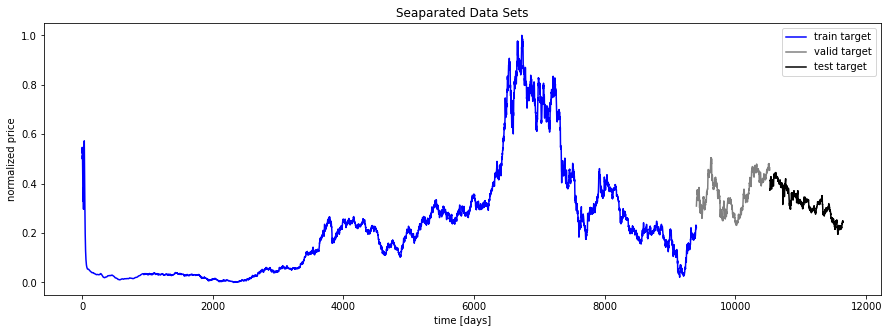

In [0]:
## show predictions
plt.figure(figsize=(15, 5))

plt.plot(np.arange(y_train_2.shape[0]), y_train_2, color='blue', label='train target')

plt.plot(np.arange(y_train_2.shape[0], y_train_2.shape[0]+y_valid.shape[0]), y_valid,
         color='gray', label='valid target')

plt.plot(np.arange(y_train_2.shape[0]+y_valid.shape[0],
                   y_train_2.shape[0]+y_valid.shape[0]+y_test.shape[0]),
         y_test, color='black', label='test target')


plt.title('Seaparated Data Sets')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

In [0]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [0]:
EPOCHS = 10  # how many passes through our data
BATCH_SIZE = 1024  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
import time

NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [0]:
!pip install -q tensorflow==2.0.0-alpha0

    100% |████████████████████████████████| 79.9MB 309kB/s 
    100% |████████████████████████████████| 3.0MB 5.4MB/s 
    100% |████████████████████████████████| 419kB 17.9MB/s 
    100% |████████████████████████████████| 61kB 21.6MB/s 


In [0]:
# https://www.kaggle.com/shujian/transformer-with-lstm

import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
from tensorflow.python.keras.layers import Layer
from tensorflow.keras import backend as K

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass



embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask

class Transformer():
    def __init__(self, len_limit, embedding_matrix, d_model=embed_size, \
              d_inner_hid=512, n_head=10, d_k=64, d_v=64, layers=2, dropout=0.1, \
              share_word_emb=False, **kwargs):
        self.name = 'Transformer'
        self.len_limit = len_limit
        self.src_loc_info = False # True # sl: fix later
        self.d_model = d_model
        self.decode_model = None
        d_emb = d_model

        pos_emb = Embedding(len_limit, d_emb, trainable=False, \
                            weights=[GetPosEncodingMatrix(len_limit, d_emb)])

        i_word_emb = Embedding(max_features, d_emb, weights=[embedding_matrix]) # Add Kaggle provided embedding here

        self.encoder = Encoder(d_model, d_inner_hid, n_head, d_k, d_v, layers, dropout, \
                               word_emb=i_word_emb, pos_emb=pos_emb)

        
    def get_pos_seq(self, x):
        mask = K.cast(K.not_equal(x, 0), 'int32')
        pos = K.cumsum(K.ones_like(x, 'int32'), 1)
        return pos * mask

    def compile(self, active_layers=999):
        src_seq_input = Input(shape=(None, ))
        x = Embedding(max_features, embed_size, weights=[embedding_matrix])(src_seq_input)
        
        # LSTM before attention layers
        x = Bidirectional(LSTM(128, return_sequences=True))(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
        x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
        
        avg_pool = GlobalAveragePooling1D()(x)
        max_pool = GlobalMaxPooling1D()(x)
        conc = concatenate([avg_pool, max_pool])
        conc = Dense(64, activation="relu")(conc)
        x = Dense(1, activation="sigmoid")(conc)   
        
        
        self.model = Model(inputs=src_seq_input, outputs=x)
        self.model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

In [0]:
print(tf.__version__)

2.0.0-alpha0


In [0]:
!pip install -q h5py pyyaml 

In [0]:
def build_model():
    inp = Input(shape = (SEQ_LEN, 1))
    
    # LSTM before attention layers
    x = Bidirectional(LSTM(128, return_sequences=True))(inp)
    x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
    x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
        
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(64, activation="relu")(conc)
    x = Dense(1, activation="sigmoid")(conc)      

    model = Model(inputs = inp, outputs = x)
    model.compile(
        loss = "mean_squared_error", 
        #optimizer = Adam(lr = config["lr"], decay = config["lr_d"]), 
        optimizer = "adam")
    
    # Save entire model to a HDF5 file
    model.save_weights('stock_predictor.h5')
    
    return model

In [0]:
multi_head = build_model()

In [0]:
multi_head.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 60, 256)      133120      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 60, 128)      164352      bidirectional[0][0]              
__________________________________________________________________________________________________
dense (Dense)                   (None, 60, 192)      24576       bidirectional_1[0][0]            
______________________________________________________________________________________________

In [0]:
multi_head.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid), 
                    #callbacks = [checkpoint , lr_reduce]
             )

Train on 9402 samples, validate on 1123 samples
Epoch 1/10
9402/9402 [==============================] - 66s 7ms/sample - loss: 0.0608 - val_loss: 0.0012
Epoch 2/10
9402/9402 [==============================] - 62s 7ms/sample - loss: 0.0083 - val_loss: 0.0021
Epoch 3/10
9402/9402 [==============================] - 62s 7ms/sample - loss: 0.0032 - val_loss: 0.0021
Epoch 4/10
9402/9402 [==============================] - 61s 6ms/sample - loss: 0.0019 - val_loss: 0.0028
Epoch 5/10
9402/9402 [==============================] - 61s 6ms/sample - loss: 0.0015 - val_loss: 0.0024
Epoch 6/10
9402/9402 [==============================] - 61s 7ms/sample - loss: 0.0014 - val_loss: 0.0049
Epoch 7/10
9402/9402 [==============================] - 62s 7ms/sample - loss: 0.0014 - val_loss: 0.0028
Epoch 8/10
9402/9402 [==============================] - 62s 7ms/sample - loss: 0.0013 - val_loss: 0.0049
Epoch 9/10
9402/9402 [==============================] - 61s 7ms/sample - loss: 0.0013 - val_loss: 0.0043
Epoch 1

In [0]:
predicted_stock_price_multi_head = multi_head.predict(X_test)
#predicted_stock_price = scaler.inverse_transform(predicted_stock_price)


print(type(predicted_stock_price_multi_head))

<class 'numpy.ndarray'>


In [0]:
X_test.shape

(1122, 60, 1)

In [0]:
predicted_stock_price_multi_head = np.vstack((np.full((60,1), np.nan), predicted_stock_price_multi_head))
print(predicted_stock_price_multi_head[1000])


[0.23922271]


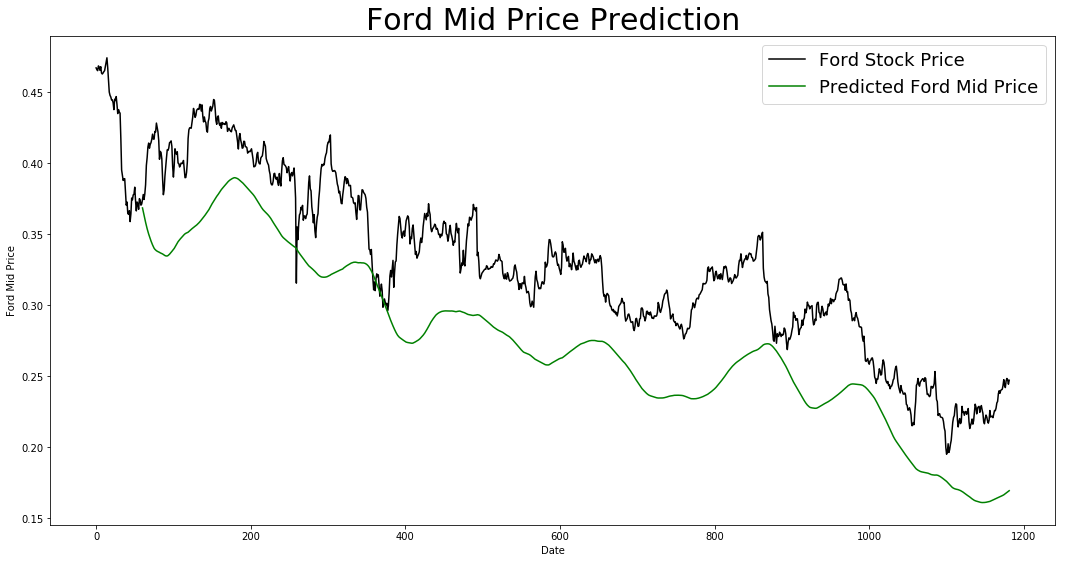

In [0]:
plt.figure(figsize = (18,9))
plt.plot(test_data, color = 'black', label = 'Ford Stock Price')
plt.plot(predicted_stock_price_multi_head, color = 'green', label = 'Predicted Ford Mid Price')
plt.title('Ford Mid Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=0)
plt.xlabel('Date')
plt.ylabel('Ford Mid Price')
plt.legend(fontsize=18)
plt.show()

In [0]:
min_val = 1
max_val = 0
max_index = 0
min_index = 0
for i in range(0,len(predicted_stock_price_multi_head)):
  if predicted_stock_price_multi_head[i] < min_val:
    min_val = predicted_stock_price_multi_head[i]
    min_index = i
  if predicted_stock_price_multi_head[i] > max_val:
    max_val = predicted_stock_price_multi_head[i]
    max_index = i
  
risk = 0.2  

if min_index<max_index:
  covered_call_date = 0;
  uncovered_put_date = min_index
  expiry_call = min_index
  expiry_put = max_index
  strike_call = predicted_stock_price_multi_head[0] - (predicted_stock_price_multi_head[0] - min_val)*risk
  strike_put = min_val + (max_val - min_val)*risk
  premium_call = (predicted_stock_price_multi_head[0] - min_val)*risk
  premium_put = (max_val - min_val)*risk
  print("Write a Covered Call Option in ",covered_call_date," days with an expiry date in ",expiry_call," days, a strike price of $",strike_call," per stock and a premium of $",premium_call)
  print("Write an Uncovered Put Option in ",uncovered_put_date," days with an expiry date in ",expiry_put," days, a strike price of $",strike_put," per stock and a premium of $",premium_put)
  
if max_index<min_index:
  uncovered_put_date = 0;
  covered_call_date = max_index
  expiry_put = max_index
  expiry_call = min_index
  strike_put = predicted_stock_price_multi_head[1] + (max_val - predicted_stock_price_multi_head[1])*risk
  strike_call = max_val - (max_val - min_val)*risk
  premium_call = (max_val - predicted_stock_price_multi_head[1])*risk
  premium_put = (max_val - min_val)*risk
  print("Write an Uncovered Put Option in ",uncovered_put_date," days with an expiry date in ",expiry_put," days, a strike price of $",strike_put," per stock and a premium of $",premium_put)
  print("Write a Covered Call Option in ",covered_call_date," days with an expiry date in ",expiry_call," days, a strike price of $",strike_call," per stock and a premium of $",premium_call)
 

Write an Uncovered Put Option in  0  days with an expiry date in  179  days, a strike price of $ [nan]  per stock and a premium of $ [0.04578633]
Write a Covered Call Option in  179  days with an expiry date in  1147  days, a strike price of $ [0.34401619]  per stock and a premium of $ [nan]


In [0]:
cd ..

/content


In [0]:
!pwd

/content


In [0]:
!pip install simple_tensorflow_serving

In [0]:
simple_tensorflow_serving --model_base_path="./models/tensorflow_template_application_model"